# Imputation of missing values using Matrix Factorization

This is a short example about imputation of missing values using the package [cmfrec](https://github.com/david-cortes/cmfrec) (low-rank matrix factorization), which among other things, can be used for imputation of tabular data using matrix factorization models.

The basic idea is to produce an approximate factorization of a matrix $\mathbf{X}$ with misisng data as the product of two lower-dimensional matrices, determined by finding two such matrices that minimize the squared error with respect to the non-missing entries:
$$
\mathbf{X} \approx \mathbf{A} \mathbf{B}^T
$$

Optionally adding other aspects such as centering and column means - e.g.:
$$
\mathbf{X} \approx \mathbf{A} \mathbf{B}^T + \mu + \mathbf{b}
$$

Missing values are then imputed according to the the values that such factorization (fitted to the non-missing values) would produce.

Typically, values imputed in this way are not as good quality as those produce by iterative imputation methods, but for high-dimensional data, such a model is typically faster to fit and to produce imputations.

Note that `cmfrec` is aimed primarily at recommender systems, and using it for imputation of tabular data benefits from changing the default parameters - particularly: do not add user (row) biases, and do not regularize the item biases (column intercepts). See the code below for an example of changing these parameters.

For more information about the library and methods, see the package's webpage:
https://github.com/david-cortes/cmfrec
** *
The example here is copy-pasted from SciKit-Learn's usage guide for their imputer, and just adds a few extra lines that do the job with this package.

Original code was taken from this link:

https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py

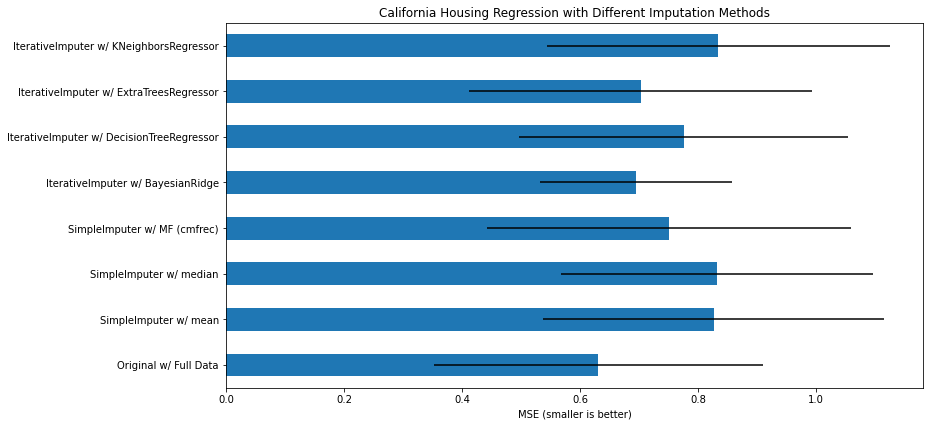

In [1]:
### As of 2021-07-21, SciKit-Learn's example throws lots of convergence warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

N_SPLITS = 5

rng = np.random.RandomState(0)

X_full, y_full = fetch_california_housing(return_X_y=True)
# ~2k samples is enough for the purpose of the example.
# Remove the following two lines for a slower run with different error bars.
X_full = X_full[::10]
y_full = y_full[::10]
n_samples, n_features = X_full.shape

# Estimate the score on the entire dataset, with no missing values
br_estimator = BayesianRidge()
score_full_data = pd.DataFrame(
    cross_val_score(
        br_estimator, X_full, y_full, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    ),
    columns=['Full Data']
)

# Add a single missing value to each row
X_missing = X_full.copy()
y_missing = y_full
missing_samples = np.arange(n_samples)
missing_features = rng.choice(n_features, n_samples, replace=True)
X_missing[missing_samples, missing_features] = np.nan

# Estimate the score after imputation (mean and median strategies)
score_simple_imputer = pd.DataFrame()
for strategy in ('mean', 'median'):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy),
        br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_missing, y_missing, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    )

    
##### NEW ADDITION HERE #########
# This is the piece of code that adds imputations with cmfrec
from cmfrec import CMF_imputer
estimator = make_pipeline(
    CMF_imputer(k=10, user_bias=False, lambda_=[0,0,10,10,10,10],
                verbose=False),
    br_estimator
)
score_simple_imputer["MF (cmfrec)"] = cross_val_score(
    estimator, X_missing, y_missing, scoring='neg_mean_squared_error',
    cv=N_SPLITS
)
##### END OF NEW ADDITION #########


# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15)
]
score_iterative_imputer = pd.DataFrame()
for impute_estimator in estimators:
    estimator = make_pipeline(
        IterativeImputer(random_state=0, estimator=impute_estimator),
        br_estimator
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = \
        cross_val_score(
            estimator, X_missing, y_missing, scoring='neg_mean_squared_error',
            cv=N_SPLITS
        )

scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys=['Original', 'SimpleImputer', 'IterativeImputer'], axis=1
)

# plot california housing results
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title('California Housing Regression with Different Imputation Methods')
ax.set_xlabel('MSE (smaller is better)')
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([" w/ ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()